In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import scipy.stats as stats

In [2]:
# load train data
train = pd.read_csv('microarray_train.csv', index_col=0)

# save indexes of ALL and AML samples
allidx = train[train['cancer']=='ALL'].index
#print(allidx)
amlidx = train[train['cancer']=='AML'].index
#print(amlidx)

# seprate target from features
target = train.pop('cancer')
print(train.shape)
train.head()

(38, 7129)


,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25


In [3]:
# label encode target, ALL:0, AML:1
le = LabelEncoder()
target = le.fit_transform(target)
print(le.classes_)
target

['ALL' 'AML']


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

count    7.129000e+03
mean     6.820928e+05
std      3.845060e+06
min      4.769018e+02
25%      8.210373e+03
50%      3.170128e+04
75%      1.295735e+05
max      1.609285e+08
Name: variance, dtype: float64


(array([7.064e+03, 4.500e+01, 1.200e+01, 4.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([4.76901849e+02, 1.60932810e+07, 3.21860850e+07, 4.82788891e+07,
        6.43716931e+07, 8.04644972e+07, 9.65573013e+07, 1.12650105e+08,
        1.28742909e+08, 1.44835713e+08, 1.60928518e+08]),
 <BarContainer object of 10 artists>)

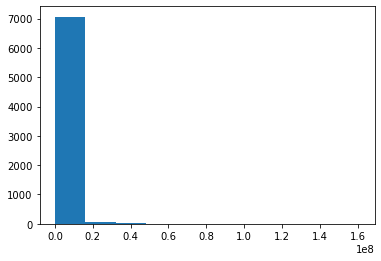

In [4]:
metrics = pd.DataFrame()
metrics['variance'] = train.var()
#metrics['variance'] = np.log2(train).var()
print(metrics['variance'].describe())
#alpha, loc, beta = stats.gamma.fit(metrics['variance'])
#plt.hist(x=np.log2(metrics['variance']), bins=50)
plt.hist(x=metrics['variance'])

#x = np.linspace(0, metrics['variance'].max(), 100)
# fit
#param = stats.gamma.fit(metrics['variance'], floc=0)
#pdf_fitted = stats.gamma.pdf(x, *param)
#plt.plot(x, pdf_fitted, color='r')

#x = np.linspace(0, np.log2(metrics['variance']).max(), 100)
# fit
#param = stats.gamma.fit(np.log2(metrics['variance']), floc=0)
#pdf_fitted = stats.gamma.pdf(x, *param)
#plt.plot(x, pdf_fitted, color='r')


In [5]:
metrics['pctvalpos'] = [sum(train[col]>0)/len(train[col]) for col in train.columns]
metrics.describe()

,variance,pctvalpos
count,7.129000e+03,7129.000000
mean,6.820928e+05,0.712394
std,3.845060e+06,0.354564
min,4.769018e+02,0.000000
25%,8.210373e+03,0.447368
50%,3.170128e+04,0.921053
75%,1.295735e+05,1.000000
max,1.609285e+08,1.000000


In [6]:
metrics[metrics['pctvalpos']>0.5].describe()

,variance,pctvalpos
count,5.163000e+03,5163.000000
mean,8.822834e+05,0.913275
std,4.357697e+06,0.129808
min,5.491074e+02,0.526316
25%,1.066643e+04,0.868421
50%,4.043881e+04,0.973684
75%,1.835392e+05,1.000000
max,1.609285e+08,1.000000


In [7]:
metrics['mi'] = mutual_info_classif(train, target)

In [8]:
# compute regular p-values for each feature between ALL and AML 
pval=[]
for col in range(len(train.columns)):
    pval.append(stats.ttest_ind(train.iloc[amlidx,col], train.iloc[allidx,col], equal_var=False)[1]) # store p-val
metrics['pval'] = pval    
#ttest_ind(train.iloc[amlidx,0], train.iloc[allidx,0], equal_var=False)


In [9]:
# compute p-values with stats for each feature between ALL and AML 
pval2 = []
for col in range(len(train.columns)):
    #allvar.append(np.var(train.iloc[allidx,col]))
    #allvar.append(np.var(train.iloc[amlidx,col]))
    m1 = train.iloc[allidx,col].mean()
    sd1 = np.std(train.iloc[allidx,col])
    m2 = train.iloc[amlidx,col].mean()
    sd2 = np.std(train.iloc[amlidx,col])
    pval2.append(stats.ttest_ind_from_stats(mean1=m1, std1=sd1, nobs1=len(allidx),\
                                            mean2=m2, std2=sd2, nobs2=len(amlidx), equal_var=False)[1])
metrics['pval2'] = pval2


In [10]:
metrics.describe()

,variance,pctvalpos,mi,pval,pval2
count,7.129000e+03,7129.000000,7129.000000,7.129000e+03,7.129000e+03
mean,6.820928e+05,0.712394,0.053121,3.426886e-01,3.323058e-01
std,3.845060e+06,0.354564,0.071908,3.082058e-01,3.077542e-01
min,4.769018e+02,0.000000,0.000000,8.388715e-09,5.716337e-09
25%,8.210373e+03,0.447368,0.000000,5.578156e-02,4.742427e-02
50%,3.170128e+04,0.921053,0.021545,2.591065e-01,2.419525e-01
75%,1.295735e+05,1.000000,0.084948,5.888123e-01,5.750780e-01
max,1.609285e+08,1.000000,0.537751,9.996315e-01,9.996186e-01


In [11]:
metrics

,variance,pctvalpos,mi,pval,pval2
AFFX-BioB-5_at,12002.441679,0.105263,0.079546,0.185434,0.169042
AFFX-BioB-M_at,5735.715505,0.000000,0.000000,0.334354,0.316054
AFFX-BioB-3_at,13850.028450,0.342105,0.000000,0.818418,0.812342
AFFX-BioC-5_at,13798.731863,0.921053,0.158517,0.002964,0.002129
AFFX-BioC-3_at,12321.983642,0.000000,0.044994,0.942938,0.940562
...,...,...,...,...,...
X83863_at,232677.402560,1.000000,0.000000,0.094710,0.082057
Z17240_at,44027.271693,1.000000,0.006453,0.818077,0.811890
L49218_f_at,970.873400,0.789474,0.066114,0.110234,0.099211
M71243_f_at,531068.407539,0.973684,0.174915,0.022379,0.017832


<AxesSubplot:xlabel='pval2', ylabel='Count'>

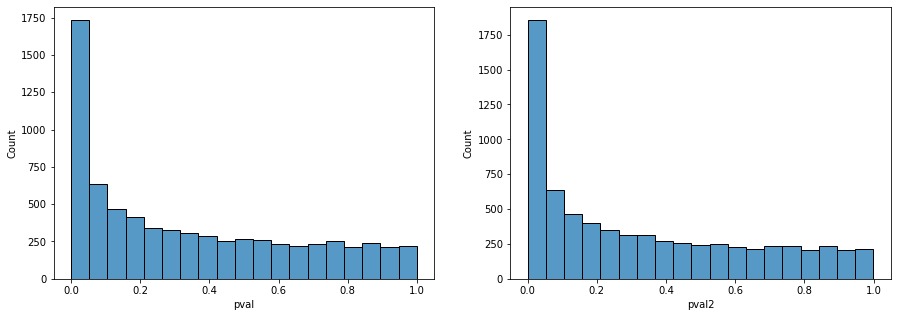

In [12]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.histplot(x='pval', data=metrics, ax=axs[0])
sns.histplot(x='pval2', data=metrics, ax=axs[1])

In [13]:
metrics[metrics['mi']>=0.15].describe()

,variance,pctvalpos,mi,pval,pval2
count,7.590000e+02,759.000000,759.000000,7.590000e+02,7.590000e+02
mean,1.330063e+06,0.776819,0.215305,9.554623e-02,9.131037e-02
std,4.681700e+06,0.319545,0.063014,2.050974e-01,2.024865e-01
min,1.007588e+03,0.000000,0.150135,8.388715e-09,5.716337e-09
25%,2.402131e+04,0.657895,0.168523,5.809087e-04,4.175443e-04
50%,8.665593e+04,0.947368,0.194606,6.635882e-03,5.041352e-03
75%,4.418328e+05,1.000000,0.241923,5.286808e-02,4.435712e-02
max,6.425958e+07,1.000000,0.537751,9.816323e-01,9.810746e-01


In [14]:
metrics[metrics['mi']>=0.15].index

Index(['AFFX-BioC-5_at', 'AFFX-PheX-M_at', 'AFFX-HUMRGE/M10098_5_at',
       'AFFX-HUMRGE/M10098_3_at', 'AFFX-HUMTFRR/M11507_5_at',
       'AFFX-HUMTFRR/M11507_M_at', 'AFFX-HUMTFRR/M11507_3_at',
       'AC002115_cds4_at', 'AC002464_at', 'AF000231_at',
       ...
       'U20499_at', 'U21689_at', 'Z68193_at', 'M27749_r_at', 'D38437_f_at',
       'J00117_f_at', 'V01516_f_at', 'L10717_at', 'U29175_at', 'M71243_f_at'],
      dtype='object', length=759)

In [18]:
metrics[metrics['pval']<=0.001].describe() 

,variance,pctvalpos,mi,pval,pval2
count,3.050000e+02,305.000000,305.000000,3.050000e+02,3.050000e+02
mean,1.229436e+06,0.854012,0.203881,3.044973e-04,2.209571e-04
std,3.873855e+06,0.247360,0.086714,2.887298e-04,2.141301e-04
min,1.067118e+03,0.000000,0.025190,8.388715e-09,5.716337e-09
25%,2.886974e+04,0.842105,0.146402,4.774308e-05,3.364164e-05
50%,1.246614e+05,1.000000,0.190051,2.118560e-04,1.438468e-04
75%,5.686208e+05,1.000000,0.255808,5.109704e-04,3.496214e-04
max,3.533861e+07,1.000000,0.537751,9.969706e-04,7.356419e-04


In [ ]:
sns.pairplot(data=train[train.columns[20:25]])
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(data=train[train.columns[0:5]], orient='h')
corrmat = train[train.columns[0:5]].corr()
sns.heatmap(corrmat, vmin=-1,vmax=1, center=0)